Here's an example with an alternative GUI.

https://stackoverflow.com/questions/15460706/opencv-cv2-in-python-videocapture-not-releasing-camera-after-deletion

In [108]:
from collections import deque
import cv2
import time
import tkinter as tk
from PIL import Image, ImageTk

In [109]:
from src.sources.polar_mapping import generateLUT, convert_image
import numpy as np

In [110]:
def display(image_array, label):
    """Convert image array to image for display.
    
    Args:
        image_array - 2D numpy array.
        label - tkinter label for display.
    Returns:
        la
    """
    a = Image.fromarray(image_array)
    b = ImageTk.PhotoImage(image=a)
    label.configure(image=b)
    label._image_cache = b

Can we create sub-classes for each GUI component?

In [111]:
class CameraGUI:
    
    def __init__(self, src=0, phase_width=256):
        # Set Up Camera and LUT for Polar Mapping
        self.cam = cv2.VideoCapture(src)
        self.cam.set(cv2.CAP_PROP_CONVERT_RGB, 0)
        # Capture a frame to set image sizes
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        self.centre = np.asarray(Y.shape) // 2
        self.final_radius = self.centre.min()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(self.final_radius, phase_width=phase_width)
        # Setup gui
        self.window = tk.Tk()
        # label for the original video frame
        self.original_image = tk.Label(master=self.window)
        self.original_image.grid(row=1, column=0)
        # label for the polar video frame
        self.polar_image = tk.Label(master=self.window)
        self.polar_image.grid(row=1, column=1)
        # Label for right image
        self.right_image = tk.Label(master=self.window)
        self.right_image.grid(row=2, column=0)
        # Label for left image
        self.left_image = tk.Label(master=self.window)
        self.left_image.grid(row=2, column=1)
        
        # label for fps
        self.fps_label = tk.Label(master=self.window)
        self.fps_label.grid(row=0, column=0)
        self.fps_label._frame_times = deque([0]*5)  # arbitrary 5 frame average FPS
        # quit button
        self.quit_button = tk.Button(master=self.window, text='Quit', command=lambda: self.quit_())
        self.quit_button.grid(row=0, column=1)
        # setup the update callback
        self.window.after(0, func=lambda: self.update_all())
    
    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        # Show original frame at reduced resolution
        down_one = cv2.pyrDown(Y)
        display(cv2.pyrDown(down_one), self.original_image)
        # Can change this to internal method
        converted = convert_image(Y, self.LUT)
        display(cv2.pyrDown(converted), self.polar_image)
        # Show left / right hemisphere images
        rows, cols = converted.shape
        # right_image = np.flipud(converted[:, :cols//2].T)
        # left_image = np.fliplr(converted[:, cols//2:].T)
        right_image = np.flipud(converted[:, :cols//2].T)
        left_image = np.fliplr(converted[:, cols//2:].T)
        display(right_image, self.right_image)
        display(left_image, self.left_image)
        return converted
        
    
    def update_fps(self):
        frame_times = self.fps_label._frame_times
        frame_times.rotate()
        frame_times[0] = time.time()
        sum_of_deltas = frame_times[0] - frame_times[-1]
        count_of_deltas = len(frame_times) - 1
        try:
            fps = int(float(count_of_deltas) / sum_of_deltas)
        except ZeroDivisionError:
            fps = 0
        self.fps_label.configure(text=f'FPS: {fps}')
        
    def update_all(self):
        _ = self.update_image()
        # Update Window
        self.window.update()
        self.update_fps()
        self.window.after(20, func=lambda: self.update_all())
    
    def run(self):
        self.window.mainloop()
        
    def quit_(self):
        self.cam.release()
        self.window.destroy()

In [ ]:
camGUI = CameraGUI(src=2)

camGUI.run()

In [112]:
from src.sources.polar_mapping import setup_reduced_res, reduce_resolution

In [113]:
class CamGUIReduced(CameraGUI):
    
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        # Setup reduced resolution parameters
        self.precomputed = setup_reduced_res(self.phase_width)
        # label for the reduced resolution quadrants
        self.reduced_image_right_top = tk.Label(master=self.window)
        self.reduced_image_right_top.grid(row=3, column=0)
        self.reduced_image_right_bot = tk.Label(master=self.window)
        self.reduced_image_right_bot.grid(row=4, column=0)
        self.reduced_image_left_top = tk.Label(master=self.window)
        self.reduced_image_left_top.grid(row=3, column=1)
        self.reduced_image_left_bot = tk.Label(master=self.window)
        self.reduced_image_left_bot.grid(row=4, column=1)
    
    def update_image(self):
        converted = super().update_image()
        # Show reduced image
        output_list, output_image = reduce_resolution(
            converted, output_display=True, precomputed=self.precomputed)
        rows, cols = output_image.shape
        # right_image = np.flipud(converted[:, :cols//2].T)
        # left_image = np.fliplr(converted[:, cols//2:].T)
        right_image = output_image[:, :cols//2].T
        left_image = np.flip(output_image[:, cols//2:].T)
        # Split in half again vertically to show - could replace these with list + for loop
        rows, cols = right_image.shape
        display(right_image[:rows//2, :], self.reduced_image_right_top)
        display(right_image[rows//2:, :], self.reduced_image_right_bot)
        display(left_image[:rows//2, :], self.reduced_image_left_top)
        display(left_image[rows//2:, :], self.reduced_image_left_bot)
    

In [114]:
camGUI2 = CamGUIReduced(src=2)

camGUI2.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-111-b3268880b34c>", line 78, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "<ipython-input-111-b3268880b34c>", line 77, in update_all
    self.update_fps()
  File "<ipython-input-111-b3268880b34c>", line 71, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 1476, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
_tkinter.TclError: invalid co

Is face alignment just a matter of syncing the eyes and the mouth in the quadrants?

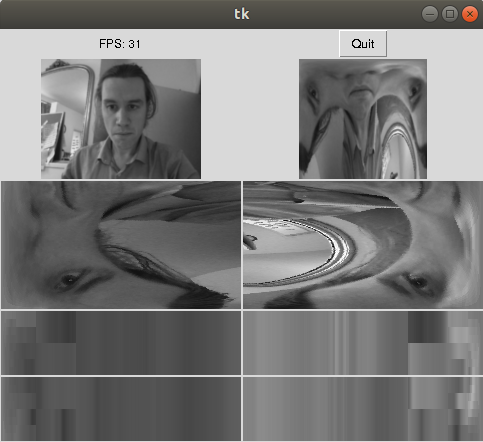

## Todo:

* View each color component.
* PBT.
* Centring on object.
* Refactor to make it easier to add panels.
* Convert to using a source object.
* Add sound as well.
* Add system features.
* Testing!!

Here it explains how to create an image from a figure.
https://stackoverflow.com/questions/8598673/how-to-save-a-pylab-figure-into-in-memory-file-which-can-be-read-into-pil-image/8598881

Order for above:
* Add in a set of raw PBT figures.
* Then add in a set of PBT based on rolling average.

As these can be built relatively modular by just adding extra rows. Then we can just duplicate the stack for each colour component. This will also involve some refactoring...

### Initial Refactoring

In [7]:
from src.sources.abstract import CombinedSource
from src.sources.fft import FFTSource
from src.sources.video import VideoSource

class FFTAVCapture(CombinedSource):
    """Auto populate with audio and video."""

    def __init__(self, src=0):
        """Initialise."""
        super().__init__()
        audio = FFTSource()
        self.add_source(audio, "audio")
        video = VideoSource(src=src)
        self.add_source(video, "video")

In [15]:
from src.sources.video import separate_components

In [8]:
sensors = FFTAVCapture(src=2)
sensors.start()

In [9]:
data = sensors.read()

In [10]:
data

{'audio': array([  0,   0,   0,   8,   0,  18,  22,   0,  33,  49,  60,  70,  20,
        141, 106, 146, 162,  96, 129, 159, 199, 203,  97, 223, 215,   1,
        182, 206,  71, 154, 166,  97, 171, 238, 134, 210,  72,  59,  81,
         75,  70,  82, 112, 149,  24, 101, 145, 123, 121,  82,  89,  77,
        108,  97, 102,  99, 125, 102,  83, 186,  86,  77, 121,  56, 103,
         40,  51,  35,  46,  32,  34,  43,  43,  47,  48,  47,  67,  56,
         81,  59,  50,  40,  68,  43,  24,  29,  30,  32,  35,  29,  25,
         31,  19,  16,  16,  18,  15,  15,  14,  10,  10,  10,   8,   8,
          8,   8,   8,   6,   7,   7,   7,   6,   6,   5,   5,   5,   5,
          5,   5,   5,   5,   5,   5,   4,   4,   4,   4,   5,   4,   4,
          4,   4,   4,   4,   4,   4,   4], dtype=uint8),
 'video': array([[[228, 128],
         [228, 123],
         [228, 126],
         ...,
         [178, 121],
         [163, 126],
         [161, 123]],
 
        [[228, 127],
         [229, 123],
         

In [11]:
isinstance(sensors, CombinedSource)

True

In [12]:
sensors.started

True

In [13]:
data["video"].shape

(480, 640, 2)

In [17]:
Y, U, V = separate_components(data["video"])
Y.shape, U.shape, V.shape

((480, 640), (240, 320), (240, 320))

In [68]:
class AbstractCameraGUI:
    
    def __init__(self):
        """Initialise."""
        # Setup GUI
        self.window = tk.Tk()
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # label for fps
        self.fps_label = tk.Label(button_frame)
        self.fps_label.pack(side=tk.LEFT, padx=5, pady=5)
        self.fps_label._frame_times = deque([0]*5)  # arbitrary 5 frame average FPS
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        # setup the update callback
        self.window.after(0, func=lambda: self.update_all())

    def update_fps(self):
        """Update FPS value."""
        frame_times = self.fps_label._frame_times
        frame_times.rotate()
        frame_times[0] = time.time()
        sum_of_deltas = frame_times[0] - frame_times[-1]
        count_of_deltas = len(frame_times) - 1
        try:
            fps = int(float(count_of_deltas) / sum_of_deltas)
        except ZeroDivisionError:
            fps = 0
        self.fps_label.configure(text=f'FPS: {fps}')
        
    def update_all(self):
        """Update all components."""
        _ = self.update_image()
        # Update Window
        self.window.update()
        self.update_fps()
        self.window.after(20, func=lambda: self.update_all())
    
    def run(self):
        """Start GUI."""
        self.window.mainloop()
        
    def quit_(self):
        """Quit GUI."""
        # self.cam.release()
        self.window.destroy()

In [69]:
class VideoFrame:
    """General class that displays a video frame."""
    
    def __init__(self, master, text="Frame"):
        """Initialise.
        
        Args:
            master - tkinter master component.
            text - string label for the frame.
        """
        self.container = tk.LabelFrame(master=master, text=text)
        self.image = tk.Label(master=self.container)
        self.image.pack()  
    
    def update(self, input_image):
        """Update components using input_image.
        
        Args:
            input_image - numpy array.
        """
        image_array = self.image_processing(input_image)
        # This is the display function from above
        a = Image.fromarray(image_array)
        b = ImageTk.PhotoImage(image=a)
        self.image.configure(image=b)
        self.image._image_cache = b
    
    def image_processing(self, input_image):
        """Generate an output image for display.
        
        Args:
            input_image - numpy array.
        Returns:
            output_image - numpy array for display.
        
        """
        return input_image

In [70]:
class FramePair:
    """Component for a left / right pair of video frames."""
    def __init__(self, master, text="FramePair"):
        """Initialise.
        
        Args:
            master - tkinter master component.
            text - string label for the frame.
        """
        self.container = tk.LabelFrame(master=master, text=text)
        self.right_image = tk.Label(master=self.container)
        # Right image goes to left hemisphere
        self.right_image.pack(side=tk.LEFT, fill=tk.BOTH, padx=5, pady=5, expand=True) 
        self.left_image = tk.Label(master=self.container)
        self.left_image.pack(side=tk.RIGHT, fill=tk.BOTH, padx=5, pady=5, expand=True)
    
    def update(self, input_image):
        """Update components using input_image.
        
        Args:
            input_image - numpy array.
        """
        right, left = self.image_processing(input_image)
        display(right, self.right_image)
        display(left, self.left_image)
    
    def image_processing(self, input_image):
        """Generate an output image for display.
        
        Args:
            input_image - numpy array.
        Returns:
            right - numpy array for right image display.
            left - numpy array for left image display.
        
        """
        rows, cols = input_image.shape
        right = np.flipud(input_image[:, :cols//2].T)
        left = np.fliplr(input_image[:, cols//2:].T)
        return right, left

In [96]:
class FrameQuadrant:
    """Component for a quadrant of left / right, top / bottom 
    video frames."""

    # The precomputed input is a fudge - we need a better way of separating
    # display and data
    def __init__(self, master, precomputed, text="FrameQuadrant"):
        """Initialise.
        
        Args:
            master - tkinter master component.
            text - string label for the frame.
        """
        self.quadrants = list()
        self.precomputed = precomputed
        self.container = tk.LabelFrame(master=master, text=text)
        # Right image goes to left hemisphere - might want to reword as confusing!
        self.right_frame = tk.Frame(master=self.container)
        self.right_frame.pack(side=tk.LEFT, fill=tk.BOTH, padx=5, pady=5, expand=True) 
        # Left image goes to right hemisphere
        self.left_frame = tk.Frame(master=self.container)
        self.left_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=5, pady=5, expand=True)
        # Build a quadrant label list - order RT, LT, RB, LB
        self.quadrants.append(tk.Label(master=self.right_frame))
        self.quadrants.append(tk.Label(master=self.left_frame))
        self.quadrants.append(tk.Label(master=self.right_frame))
        self.quadrants.append(tk.Label(master=self.left_frame))
        self.quadrants[0].pack(side=tk.TOP, fill=tk.BOTH, padx=5, pady=5)
        self.quadrants[1].pack(side=tk.TOP, fill=tk.BOTH, padx=5, pady=5)
        self.quadrants[2].pack(side=tk.BOTTOM, fill=tk.BOTH, padx=5, pady=5)
        self.quadrants[3].pack(side=tk.BOTTOM, fill=tk.BOTH, padx=5, pady=5)
    
    def update(self, input_image):
        """Update components using input_image.
        
        Args:
            input_image - numpy array.
        """
        # Images and quadrants run RT, LT, RB, LB
        images = self.image_processing(input_image)
        for image, quadrant in zip(images, self.quadrants):
            display(image, quadrant)
    
    def image_processing(self, input_image):
        """Generate an output image for display.
        
        Args:
            input_image - numpy array.
        Returns:
            right - numpy array for right image display.
            left - numpy array for left image display.
        
        """
        # Initialise list of images for output
        images = list()
        # Show reduced image
        output_list, output_image = reduce_resolution(
            input_image, output_display=True, precomputed=self.precomputed)
        # Below is the FramePair method
        rows, cols = output_image.shape
        right_image = output_image[:, :cols//2].T
        left_image = np.flip(output_image[:, cols//2:].T)
        # Split in half again vertically to show - could replace these with list + for loop
        rows, cols = right_image.shape
        images.append(right_image[:rows//2, :])
        images.append(left_image[:rows//2, :])
        images.append(right_image[rows//2:, :])
        images.append(left_image[rows//2:, :])
        return images

Bugger - the frame quadrant needs the precomputed data. We need to separate the data and the presentation as per a web-app.

In [72]:
class ImageProcessingStack:
    """Class to define an image processing stack."""

In [82]:
class CameraGUI(AbstractCameraGUI):
    
    def __init__(self, sensors, phase_width=256):
        """Initialise.
        
        Args:
            sensors - CombinedSource object (or derived object).
            phase_width - integer setting resolution for
                angle in polar mapping.
        """
        # Initialise as per abstract class
        super().__init__()# Setup GUI
        
        # Setup New Frames - this doesn't need data
        # Preview Frame
        preview_frame = tk.Frame(self.window)
        preview_frame.pack(expand=True, fill=tk.BOTH)
        # label for the original video frame
        self.original_image = VideoFrame(preview_frame, text="Image Preview")
        self.original_image.container.pack(side=tk.LEFT, expand=True, fill=tk.X)
        
        # label for the polar video frame
        self.polar_image = VideoFrame(preview_frame, text="Polar Preview")
        self.polar_image.container.pack(side=tk.LEFT, expand=True, fill=tk.X)
        
        # Label for right/left images
        self.frame_pair = FramePair(self.window, text="Right & Left Images")
        self.frame_pair.container.pack()
        
        # Setup Data Processing - this requires data
        # Initialise sensors
        assert isinstance(sensors, CombinedSource)
        # Check if sensors has been started and if not start
        self.sensors = sensors
        if not self.sensors.started:
            self.sensors.start()
        # Set Up Polar Mapping
        data = self.sensors.read()
        Y, U, V = separate_components(data["video"])
        self.centre = np.asarray(Y.shape) // 2
        self.final_radius = self.centre.min()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(self.final_radius, phase_width=phase_width)
        
    def image_processing(self):
        """Perform image processing and provide a list of images for display."""
        output_images = list()
        # Get frame
        data = self.sensors.read()
        Y, U, V = separate_components(data["video"])
        output_images.append([Y, U, V])
        # Show original frame at reduced resolution
        down_one = cv2.pyrDown(Y)
        down_two = cv2.pyrDown(down_one)
        output_images.append(down_two)
        self.original_image.update(down_two)
        # Can change this to internal method
        converted = convert_image(Y, self.LUT)
        output_images.append
        self.polar_image.update(cv2.pyrDown(converted))
        # Show left / right hemisphere images
        self.frame_pair.update(converted)
        return converted
        
    def update_image(self):
        """This could return a list of images that are then displayed separately."""
        # Get frame
        data = self.sensors.read()
        Y, U, V = separate_components(data["video"])
        # Show original frame at reduced resolution
        down_one = cv2.pyrDown(Y)
        self.original_image.update(cv2.pyrDown(down_one))
        # Can change this to internal method
        converted = convert_image(Y, self.LUT)
        self.polar_image.update(cv2.pyrDown(converted))
        # Show left / right hemisphere images
        self.frame_pair.update(converted)
        return converted
    

In [102]:
class CamGUIReduced(CameraGUI):
    
    def __init__(self, sensors, phase_width=256):
        # Call parent init
        super().__init__(sensors, phase_width)
        # Setup reduced resolution parameters
        precomputed = setup_reduced_res(self.phase_width)
        # label for the reduced resolution quadrants
        self.frame_quadrant = FrameQuadrant(self.window, precomputed, "Right / Left - Top / Bottom")
        self.frame_quadrant.container.pack()
    
    def update_image(self):
        converted = super().update_image()
        self.frame_quadrant.update(converted)

In [83]:
camGUI = CameraGUI(sensors)

camGUI.run()

In [106]:
sensors.stop()

A slowdown of ~5 FPS for the joint video and audio (25/26 FPS). We'll need to benchmark to see where best to speed up as we were getting 30 FPS for just video with direct cv2 methods.

Down to 22-23 FPS with a large display image.

We want a list of labels that we populate with a corresponding list of images. 
* We thus have an ```add``` (or ```init```?) method that generates the frame or label. 
* We also has an ```update``` method that takes an input image and updates the label.
* In the ```update``` or in a separate ```image_processing``` method we also transform the input to the output image or images for display.

In the update image we can't just iterate through because different panels have different images. And some receive the output of other images.

Maybe we just want to pack the components? We do this using frames and frames within frames. If we have left and right we can use pack(side=tk.LEFT/RIGHT, fill=tk.BOTH, expand=True) to fill each half.

We organise the pipeline as a class hierarchy - we add more features with each class and add the final child class as a component. The class 

In [105]:
camGUI2 = CamGUIReduced(sensors)

camGUI2.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-68-ad1b240a6ffb>", line 39, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "<ipython-input-68-ad1b240a6ffb>", line 38, in update_all
    self.update_fps()
  File "<ipython-input-68-ad1b240a6ffb>", line 31, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/tkinter/__init__.py", line 1476, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
_tkinter.TclError: invalid comma

We want to separate the frame views from the data processing.

We have the following frame view arrangements:
* single image
* two images
* four images

For one image we have a single frame.
For two images we split the single frame into two frames horizontally - we want to split harder by hemisphere.
For four images we split each of the two frames into two.

We could use a common method that splits based on how many images it is to be passed. Expects a list of images.

On the ```update``` method of the GUI we have the pipeline.

We can split the CameraGUI into a pure display class and a data processing class. The data processing class returns images and other data. This also needs to be modular - so we add additional layers of processing.

What about our original sensor classes? We also want to easily incorporate views of sound and computer state and "muscle" state.

We can have processing "layers" that output a list of images. We can also have display layers that are configured based on the number of images. We can have standard patterns of image output, e.g. left, right or a hierarchy of lists - we recursively generate viewing frames.

How would this fit with having stacks for each component. 

Our original ```Sensor``` object took a sensor source and returned a shaped 1D array. It also computed and removed the mean.

So this is getting similar to our data_processing stack. 

Different modalities have different initial sensor processing stacks. This can be thought of as wrappers for the initial source.

A sensor could have a configurable number of pre-processing stages. Each pre-processing stage takes a list of numpy arrays as input and generates a list of numpy arrays as output. Each stage can take an indice or set of indices indicating what portion of a previous stage is passed forward. Or we could have a dictionary style object where we have input and output and then arrays to view.

For video pre-processing stages:
* Split into components - input - frame from the camera as multidim array and outputs three Y, U, V arrays.
* Convert to polar - input - a colour component (or all color components) - output - one or more mapped arrays.
* Split into quadrants - input - one or more components - output - a list of lists - each entry having four arrays.
* Reduce resolution - input - the converted to polar image - output a list of reduced resolution arrays plus display images. (Could adapt to deal with multiple components.)
* Remove mean - input - samples over time (has state) - output mean removed arrays.
* PBT - can be binary or ternary depending if mean is removed.

For sound:
* FFT.
* Determine and remove mean.
* PBT.

So we can ```add``` a processing stack to the display that is shown in a vertical frame/column.

Each stack outputs a list of display outputs, where each display output is a list again of one or more numpy arrays. 

Each stack has a "configuration" attribute that outputs the numbers for each output that is used to construct the display components.

In [88]:
# Here's a test example of packing from here - http://zetcode.com/tkinter/layout/
from tkinter import Tk, LEFT, RIGHT, BOTH, RAISED, X, TOP
from tkinter.ttk import Frame, Button, Style

class Example(Frame):

    def __init__(self):
        super().__init__()

        self.initUI()


    def initUI(self):

        self.master.title("Buttons")
        self.style = Style()
        self.style.theme_use("default")

        frame = Frame(self, relief=RAISED, borderwidth=1)
        frame.pack(fill=BOTH, expand=True)

        self.pack(fill=BOTH, expand=True)

        closeButton = Button(self, text="Close")
        closeButton.pack(side=LEFT, fill=BOTH, padx=5, pady=5, expand=True)
        okButton = Button(self, text="OK")
        okButton.pack(side=LEFT, fill=BOTH, expand=True)
        closeButton = Button(self, text="Close")
        closeButton.pack(side=LEFT, fill=BOTH, padx=5, pady=5, expand=True)
        okButton = Button(self, text="OK")
        okButton.pack(side=LEFT, fill=BOTH, expand=True)

def main():

    root = Tk()
    root.geometry("300x200+300+300")
    app = Example()
    root.mainloop()

In [89]:
main()

In [107]:
class AbstractPreProcessing:
    """Abstract class for sensory preprocessing."""
    def __init__(self):
        pass
    
    def forward(self, input_data, visualisation=False):
        """Forward preprocessing pass.
        
        Args:
            input_data - 2D numpy array.
            visualisation - boolean flag to indicate whether
                to output visualisation data.
        Returns:
            output_data - list of one or more numpy arrays.
            visualisation_data - list of one or more numpy 
            arrays for visualisation.
        
        """
        
        # Pre-processing goes here
        output_data = input_data
        if visualisation:
            visualisation_data = output_data
        else:
            visualisation_data = None
        return ([output_data], [visualisation_data])
    
    def backward(self, input_data, visualisation=False):
        """Reverse preprocessing pass.
        
        Args:
            input_data - 2D numpy array.
            visualisation - boolean flag to indicate whether
                to output visualisation data.
        Returns:
            output_data - list of one or more numpy arrays.
            visualisation_data - list of one or more numpy 
            arrays for visualisation.
        
        """
        # Reverse pre-processing goes here
        output_data = input_data
        if visualisation:
            visualisation_data = output_data
        else:
            visualisation_data = None
        return ([output_data], [visualisation_data])

Why doe we have a class as opposed to just a method?

Where there is internal data. So only PolarMapping and ReducedMapping really need to be classes - the others can just be methods.

In [ ]:
from src.sources.polar_mapping import generateLUT, generate_backLUT, convert_image

class PolarMapping(AbstractPreProcessing):
    """Perform polar mapping."""
    
    def __init__(self, input_data, phase_width=256):
        """Setup Data Processing.
        
        Args:
            input_data - list of numpy arrays - example of input data.
            phase_width - integer representing phase/angle resolution.
        """
        # Setup polar mapping
        self.centre = np.asarray(input_data.shape) // 2
        self.final_radius = self.centre.min()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(self.final_radius, phase_width=phase_width)
        self.backLUT = generate_backLUT(self.final_radius)
        
    def forward(self, input_data, visualisation=False):
        """Forward preprocessing pass - see abstract for args."""
        output_data = convert_image(input_data, self.LUT)
        if visualisation:
            visualisation_data = output_data
        else:
            visualisation_data = None
        return (output_data, visualisation_data)
    
    def backward(self, input_data, visualisation=False):
        """Backward preprocessing pass - see abstract for args."""
        output_data = back_convert_image(input_data, self.backLUT)
        if visualisation:
            visualisation_data = output_data
        else:
            visualisation_data = None
        return (output_data, visualisation_data)
        

In [ ]:
class ReducedMapping(PolarMapping):
    
    def __init__(self, input_data, phase_width=256):
        """Setup Data Processing.
        
        Args:
            input_data - list of numpy arrays - example of input data.
            phase_width - integer representing phase/angle resolution.
        """
        super().__init__(input_data, phase_width)
        # Setup reduced resolution parameters
        self.precomputed = setup_reduced_res(self.phase_width)
        
    def forward(self, input_data, visualisation=False):
        """Forward preprocessing pass - see abstract for args."""
        (converted_image, visualisation_data) = super().forward(input_data, visualisation)
        # Build a list of different resolutions
        groupings, grouping_ranges, spacings = self.precomputed
        start = 0
        output_list = list()
        # Loop over the groupings
        for i in range(groupings.shape[0]):
            # Average over each set of groupings and add to list
            reduced = np.add.reduceat(
                image[start:start + spacings[i], :],
                grouping_ranges[i],
                axis=1
            ) // groupings[i]
            output_list.append(reduced)
        return (output_list, visualisation_data)
    
    def backward(self, input_data, visualisation=False):
        """Backward pass to reconstruct a version of the converted array.
        
        Args:
            input_data - list of arrays.
        """
        groupings, grouping_ranges, spacings = self.precomputed
        num_of_portions = len(input_data)
        output_image = None
        # Loop over the image portions in the input_data
        for i in range(num_of_portions):
            image_portion = np.repeat(input_data[i], groupings[i], axis=1)
            if output_image is None:
                output_image = image_portion
            else:
                # Concatenate rows
                output_image = np.concatenate([output_image, image_portion], axis=0)
        return output_image
        

So the image processing is:
* Input image.
* separate_components.
* for each component:
    * reduced_image = ReducedMapping.forward(component) 
    * forward_quad(reduced_image)
    
What about the reduced output_data in list form? This needs to be split into quadrants.

Also when we do PBT and mean removal this will be performed on the list not the image - so we have divergence between the data and the images visualised.

For the quadrants - we iterate through each list.

A naive flattening would just be to flatten each array in the list. We would need to remember the length of each portion in order to reshape. We can then compute the mean based on the flattened array.

A less naive flattening would be to look at dimensionality reduction in the horizontal portion in each image portion.

The brain imaging suggests that we have a thin strip in theta but fatter in r. So maybe the theta resolution in early r is spread is the r direction - if r was mapped linearly the fovea would be small in length. 

Actually the backward method for reduced mapping *is* the visualisation method.

In [ ]:
def reduce_resolution(image, output_display=False, precomputed=None):
    """Reduce resolution as per visual acuity.

    Args:
        image - 2D numpy array in polar domain - width (cols)
            - needs to be a power of 2.
        output_display - boolean indicating whether to
            calculate an output image for display.
        precomputed - triple of (groupings, grouping_ranges, spacings)
            - optionally precomputed to speed up

    Returns:
        tuple of:
            output_list - list of reduced image portions.
            output_image - image for display if output_display = True.

    """
    if precomputed is None:
        groupings, grouping_ranges, spacings = setup_reduced_res(
            image.shape[1]
        )
    else:
        groupings, grouping_ranges, spacings = precomputed
    # Build a list of different resolutions
    start = 0
    output_list = list()
    if output_display:
        # This needs to be changed in case sum > image.shape
        width = min(spacings.sum(), image.shape[0])
        shape = (width, image.shape[1])
        output_image = np.zeros(shape=shape, dtype=image.dtype)
    else:
        output_image = None
    # Loop over the groupings
    for i in range(groupings.shape[0]):
        # Average over each set of groupings and add to list
        reduced = np.add.reduceat(
            image[start:start + spacings[i], :],
            grouping_ranges[i],
            axis=1
        ) // groupings[i]
        output_list.append(reduced)
        # If output_display flag is set, generate an image for output
        if output_display:
            end = start + spacings[i]
            if end > output_image.shape[0]:
                end = output_image.shape[0]
            output_image[
                start:end, :
            ] = np.repeat(reduced, groupings[i], axis=1)
        # Set the start of the next range as the end of the previous range
        start += spacings[i]
    # Return outputs
    return output_list, output_image

In [ ]:
def forward_quad(input_data):
    """Split an image into 4.
        
    Args:
        input_data - 2D numpy array with polar image.
    """
    rows, cols = input_data.shape
    right_image = input_data[:, :cols//2].T
    left_image = np.flip(input_data[:, cols//2:].T)
    # Split in half again vertically to show - could replace these with list + for loop
    rows, cols = right_image.shape
    output_images = list()
    output_images.append(right_image[:rows//2, :])
    output_images.append(left_image[:rows//2, :])
    output_images.append(right_image[rows//2:, :])
    output_images.append(left_image[rows//2:, :])
    return output_images

def backward_quad(image_list):
    """Take four images and recombine into one.
    
    Reverses forward_quad.
        
    Args:
        image_list - list of 2D numpy array with each
            quadrant image.
    """
    # Take quadrants [0] and [2] and concatenate along axis 0
    right_image = np.concatenate((image_list[0], image_list[2]), axis=0)
    # Take quadrants [1] and [3] and concatenate along axis 0
    left_image = np.concatenate((image_list[1], image_list[3]), axis=0)
    # Take above results, transpose, flip and concatenate along axis 1
    flipped_right = right_image.T
    flipped_left = np.flip(left_image.T)
    combined_image = np.concatenate((flipped_right, flipped_left), axis=1)
    return combined_image

So in the above setup we'd:
* 

### Colour Components

For each colour component I can reuse the setup above. 

I need a function where I can pass in 